In [17]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from sklearn.metrics import silhouette_score

In [18]:
pca_df = pd.read_csv('pca_df.csv')
df_wind_scaled = pd.read_csv('df_wind_scaled.csv')
df_subset = pd.read_csv('df_subset.csv')

In [19]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

# Model based clustering

## Gaussian Mixture

In [23]:
n_components_range = range(2, 12)  
silhouette_scores = []
highest_ss = 0
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(df_wind_scaled)
    labels = gmm.predict(df_wind_scaled)
    cluster_silhouette_score = silhouette_score(df_wind_scaled, labels)
    if cluster_silhouette_score>highest_ss:
        highest_ss = cluster_silhouette_score
        best_cluster = n_components
        print('Found a new best')
print(f'number of clusters: {best_cluster} | ss = {highest_ss}')


Found a new best
number of clusters: 2 | ss = 0.23499752720029782


In [25]:
gaussian_mix = GaussianMixture(n_components=2, random_state=42, verbose=1)
gaussian_mix.fit(df_wind_scaled)

Initialization 0
  Iteration 10
Initialization converged: True


GaussianMixture(n_components=2, random_state=42, verbose=1)

In [26]:
with open('results/model_based/gaussian_mix.pickle', 'wb') as f:
    pickle.dump(gaussian_mix, f)

In [8]:
with open('results/model_based/gaussian_mix.pickle', 'rb') as f:
    gaussian_mix = pickle.load(f)

In [27]:
labels = gaussian_mix.predict(df_wind_scaled)

In [28]:
len(np.unique(labels))

2

In [29]:
pca_df = pca_df.loc[:,:'PC2']

In [ ]:
pca_df['cluster_label'] = labels
pca_df['asset_id'] = df_subset['asset_id']

df_wind_scaled['cluster_label'] = labels
df_wind_scaled['asset_id'] = df_subset['asset_id']

In [32]:
df_wind_scaled.to_csv('results/model_based/csv_labels_cut_raw/gaussian_mix.csv', index = False)

In [33]:
df_wind_scaled = df_wind_scaled.loc[:,:'2']

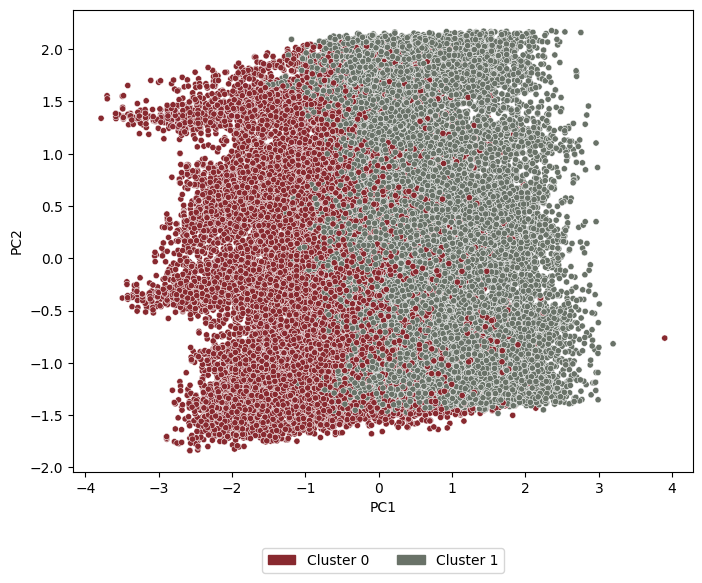

In [34]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [35]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,0.738747,-0.734238,11,1
1,-0.199476,0.074563,11,1
2,-0.311128,0.662178,11,1
3,-0.800644,-0.655436,11,1
4,1.737677,1.319443,11,1


In [36]:
len(most_frequent_clusters.unique())

2

In [37]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,0.738747,-0.734238,11,1
1,-0.199476,0.074563,11,1
2,-0.311128,0.662178,11,1
3,-0.800644,-0.655436,11,1
4,1.737677,1.319443,11,1


In [38]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,0.738747,-0.734238,1
1,12,-1.417553,-1.276716,1
2,13,1.219239,0.026342,1
3,14,-0.177437,0.586863,1
4,15,-0.862632,-1.080627,1
...,...,...,...,...
66,414,0.264004,1.670331,1
67,415,-0.666128,2.044155,1
68,510,-1.564608,-1.066597,0
69,511,-0.431002,-1.542170,1


In [39]:
pca_df = pca_df.drop(columns='asset_id')

In [40]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [6, 16, 17, 37, 38, 39, 40, 41, 42, 44, 53, 68]
Cluster 1: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 43, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70]


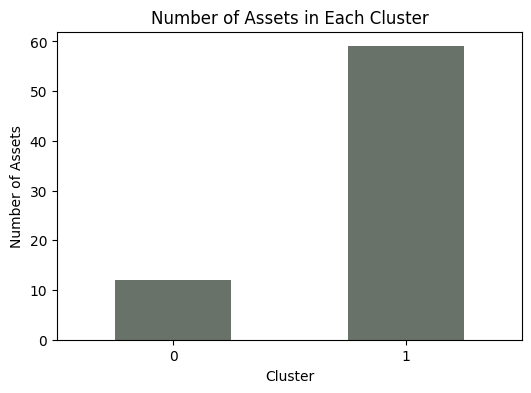

In [41]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [42]:
pca_df.to_csv('results/model_based/labels_most_common/gaussian_mix.csv', index= False)

In [43]:
pca_df = pca_df.loc[:,:'PC2']

## Bayesian GMM

In [45]:
n_components_range = range(2, 12)  
silhouette_scores = []
highest_ss = 0
for n_components in n_components_range:
    bgmm = BayesianGaussianMixture(n_components=n_components, covariance_type='full', max_iter=1000, random_state=42)
    bgmm.fit(df_wind_scaled)        
    labels = bgmm.predict(df_wind_scaled)
    cluster_silhouette_score = silhouette_score(df_wind_scaled, labels)
    if cluster_silhouette_score>highest_ss:
        highest_ss = cluster_silhouette_score
        best_cluster = n_components
        print('Found a new best')
print(f'number of clusters: {best_cluster} | ss = {highest_ss}')


Found a new best


/home/sara/.local/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


number of clusters: 2 | ss = 0.2142506307825497


In [46]:
# Fitting Bayesian Gaussian Mixture Model
bgmm = BayesianGaussianMixture(n_components=2, covariance_type='full', max_iter=1000, random_state=42)
bgmm.fit(df_wind_scaled)

# Predicting clusters for data points
labels = bgmm.predict(df_wind_scaled)

In [47]:
with open('results/model_based/bgmm.pickle', 'wb') as f:
    pickle.dump(bgmm, f)

In [26]:
with open('results/model_based/bgmm.pickle', 'rb') as f:
    bgmm = pickle.load(f)
labels = bgmm.predict(pca_df)

In [48]:
pca_df = pca_df.loc[:,:'PC2']

In [49]:
pca_df['cluster_label'] = labels
pca_df['asset_id'] = df_subset['asset_id']

df_wind_scaled['cluster_label'] = labels
df_wind_scaled['asset_id'] = df_subset['asset_id']

In [50]:
df_wind_scaled.to_csv('results/model_based/csv_labels_cut_raw/bgmm.csv', index = False)

df_wind_scaled = df_wind_scaled.loc[:,:'2']

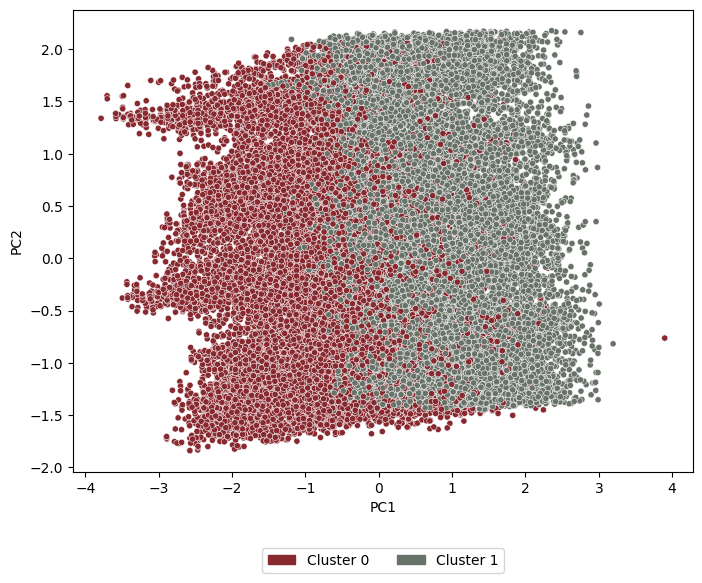

In [51]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Bayesian Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [52]:
len(np.unique(labels))

2

In [53]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,0.738747,-0.734238,11,1
1,-0.199476,0.074563,11,1
2,-0.311128,0.662178,11,1
3,-0.800644,-0.655436,11,1
4,1.737677,1.319443,11,1


In [54]:
len(most_frequent_clusters.unique())

2

In [55]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,0.738747,-0.734238,1
1,12,-1.417553,-1.276716,0
2,13,1.219239,0.026342,1
3,14,-0.177437,0.586863,1
4,15,-0.862632,-1.080627,1
...,...,...,...,...
66,414,0.264004,1.670331,1
67,415,-0.666128,2.044155,1
68,510,-1.564608,-1.066597,0
69,511,-0.431002,-1.542170,0


In [56]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [1, 6, 9, 10, 14, 15, 16, 17, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 50, 51, 53, 61, 68, 69]
Cluster 1: [0, 2, 3, 4, 5, 7, 8, 11, 12, 13, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 48, 49, 52, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 70]


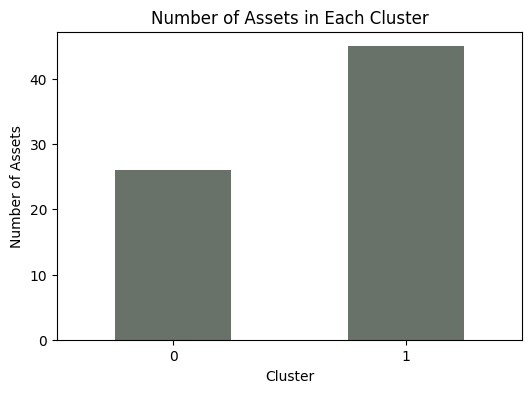

In [57]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [58]:
pca_df.to_csv('results/model_based/labels_most_common/bgmm.csv', index= False)

In [59]:
pca_df = pca_df.loc[:,:'PC2']

## Dirichlet Process Mixture Model (DPMM) 

Adapting Bayesian GMM to simulate the results from the Dirichlet Process Mixture Models: use a very high n_components to simulate the infinite cluster number

In [60]:
# dpmm = BayesianGaussianMixture(n_components=1000, covariance_type='full', max_iter=300, random_state=42)
# dpmm.fit(pca_df)

# # Predicting clusters for data points
# labels_dpmm = dpmm.predict(pca_df)

In [61]:
# with open('results/model_based/dpmm.pickle', 'wb') as f:
#     pickle.dump(dpmm, f)

In [62]:
# with open('results/model_based/dpmm.pickle', 'rb') as f:
#     dpmm = pickle.load(f)

In [63]:
# pca_df = pca_df.loc[:,:'PC2']

In [64]:
# pca_df['cluster_label'] = labels_dpmm
# pca_df['asset_id'] = df_subset['asset_id']

In [65]:
# pca_df.to_csv('results/model_based/csv_labels_cut_raw/dpmm.csv', index = False)

In [66]:
# n_clusters = len(pca_df['cluster_label'].unique())
# pallete = sns.color_palette(my_colors, n_clusters)

# # Plot the representative points on a scatter plot using PCA results
# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Dirichlet Process Mixture')
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
# plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels_dpmm)],
#            loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
# plt.show()

In [67]:
# len(np.unique(labels_dpmm))

In [68]:
# most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# # Merge the most frequent cluster labels back to the original DataFrame
# pca_df = pca_df.drop(columns = 'cluster_label')

# pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

# pca_df.head()

In [69]:
# len(most_frequent_clusters.unique())

In [70]:
# most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# # Merge the most frequent cluster labels back to the original DataFrame
# pca_df = pca_df.drop(columns='cluster_label')

# pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

# pca_df.head()

In [71]:
# representative_points = pca_df.groupby(['asset_id']).first().reset_index()
# representative_points

In [72]:
# assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# # Print assets in each cluster
# for cluster, assets in assets_clusters:
#     print(f"Cluster {cluster}: {assets.index.tolist()}")

In [73]:
# # Group assets by cluster and count the number of assets in each cluster
# cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# # Plot the number of assets in each cluster
# plt.figure(figsize=(6, 4))
# cluster_counts.plot(kind='bar', color=my_colors[1])
# plt.xlabel('Cluster')
# plt.ylabel('Number of Assets')
# plt.title('Number of Assets in Each Cluster')
# plt.xticks(rotation=0)
# plt.show()

In [74]:
# pca_df.to_csv('results/model_based/labels_most_common/dpmm.csv', index= False)